In [94]:
from __future__ import print_function
import numpy as np
import pandas as pd
import geopandas as gp
import re

import os
import sys
import zipfile 

import matplotlib.pylab as pl
%pylab inline

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GMM

from scipy.spatial.distance import cdist, pdist

Populating the interactive namespace from numpy and matplotlib


# Downloading Data

In [2]:
#these commands can be run on the shell and get the data with the command wget
#the cell needs to be run only once

'''
!for ((y=93; y<=99; y+=1)); do wget \
ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

!for ((y=0; y<=1; y+=1)); do wget \
ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=2; y<=9; y+=1)); do wget \
ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=10; y<=14; y+=1)); do wget \
ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done
'''

--2017-12-10 11:56:25--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp93totals.zip
           => “zbp93totals.zip”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Econ2001_And_Earlier/CBP_CSV ... done.
==> SIZE zbp93totals.zip ... done.
==> PASV ... done.    ==> RETR zbp93totals.zip ... 
No such file “zbp93totals.zip”.

--2017-12-10 11:56:25--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp94totals.zip
           => “zbp94totals.zip.1”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... 
Error in server response, closing control connection.
Retrying.

--2017-12-10 12:01:31--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp94totals.zip
  (try: 2) => “zbp

Logging in as anonymous ... 
Error in server response, closing control connection.
Retrying.

--2017-12-10 12:37:10--  ftp://ftp.census.gov/econ2002/CBP_CSV/zbp02totals.zip
  (try: 3) => “zbp02totals.zip.1”
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /econ2002/CBP_CSV ... done.
==> SIZE zbp02totals.zip ... 620754
==> PASV ... done.    ==> RETR zbp02totals.zip ... done.
Length: 620754 (606K) (unauthoritative)

100%[======================================>] 620,754      504K/s   in 1.2s    

2017-12-10 12:37:12 (504 KB/s) - “zbp02totals.zip.1” saved [620754]

--2017-12-10 12:37:12--  ftp://ftp.census.gov/econ2003/CBP_CSV/zbp03totals.zip
           => “zbp03totals.zip.1”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done

Logging in as anonymous ... 
Error in server response, closing control connection.
Retrying.

--2017-12-10 13:43:14--  ftp://ftp.census.gov/econ2009/CBP_CSV/zbp09totals.zip
  (try: 3) => “zbp09totals.zip.1”
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /econ2009/CBP_CSV ... done.
==> SIZE zbp09totals.zip ... 660109
==> PASV ... done.    ==> RETR zbp09totals.zip ... done.
Length: 660109 (645K) (unauthoritative)

100%[======================================>] 660,109      504K/s   in 1.3s    

2017-12-10 13:43:15 (504 KB/s) - “zbp09totals.zip.1” saved [660109]

--2017-12-10 13:43:15--  ftp://ftp.census.gov/econ2010/CBP_CSV/zbp10totals.zip
           => “zbp10totals.zip.1”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... 
Error in server response, c

In [164]:
# import the shapefiles for NYC zipcodes

shp = gp.GeoDataFrame.from_file('shp/ZIP_CODE_040114.shp')
shp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [27]:
# import the environmental variable for data directory

PUIDATA = os.getenv('PUIDATA')
PUIDATA

'/home/cusp/td928/PUIdata'

In [ ]:
# downloading NYC shapefiles by for zipcodes and release the file into a folder

!wget https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
!unzip application%2Fzip -d shp

In [6]:
df.head()

,zip,name,empflag,emp,qp1,ap,est
0,1001,"Agawam, MA",NaN,6198,33601,155158,439
1,1002,"Amherst, MA",NaN,6073,28924,127367,450
2,1003,"Amherst, MA",NaN,68,367,1604,10
3,1004,"Amherst, MA",NaN,210,844,4302,47
4,1005,"Barre, MA",NaN,678,3010,13521,92


In [7]:
df.shape

(39259, 7)

In [16]:
# Reading the zip file and creating the dataframe to hold the establishments information with each zipcode
# for each year

df = pd.DataFrame()

for file in os.listdir(pwd[0]):
    if file.endswith(".zip"):
        
        regex = re.compile(r'\d+')
        foo = int(regex.findall(file)[0])
        
        if foo < 50:
            time = foo + 2000
        else:
            time = foo + 1900
            
        zf = zipfile.ZipFile(file)
        temp = pd.read_csv(zf.open(file.replace('.zip','.txt'))).assign(year=time)
        temp.columns = map(str.lower, temp.columns)
        
        
        
        temp_ = temp[['zip', 'est', 'year']]
        
        df = pd.concat([df, temp_])

In [184]:
df.head()

,zip,est,year
0,1001,439,1994
1,1002,450,1994
2,1003,10,1994
3,1004,47,1994
4,1005,92,1994


# Preparing Data for Clusterings

In [103]:
# use pivot table to get a datafrane with each row as ip code and year as the column with 

data = df.pivot_table(index='zip', columns='year', values='est')
data.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
501,NaN,2.0,4.0,4.0,3.0,2.0,1.0,6.0,11.0,7.0,...,2.0,8.0,5.0,3.0,2.0,2.0,2.0,2.0,2.0,4.0
1000,NaN,4.0,11.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,439.0,439.0,433.0,457.0,444.0,469.0,493.0,490.0,490.0,505.0,...,509.0,509.0,503.0,477.0,458.0,448.0,436.0,453.0,439.0,458.0
1002,450.0,467.0,487.0,500.0,490.0,558.0,563.0,587.0,566.0,586.0,...,589.0,582.0,596.0,584.0,571.0,570.0,558.0,572.0,572.0,560.0
1003,10.0,10.0,13.0,15.0,14.0,13.0,13.0,13.0,15.0,16.0,...,12.0,12.0,16.0,17.0,16.0,16.0,16.0,15.0,15.0,18.0


In [104]:
data = data.dropna()
data.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
1001,439.0,439.0,433.0,457.0,444.0,469.0,493.0,490.0,490.0,505.0,...,509.0,509.0,503.0,477.0,458.0,448.0,436.0,453.0,439.0,458.0
1002,450.0,467.0,487.0,500.0,490.0,558.0,563.0,587.0,566.0,586.0,...,589.0,582.0,596.0,584.0,571.0,570.0,558.0,572.0,572.0,560.0
1003,10.0,10.0,13.0,15.0,14.0,13.0,13.0,13.0,15.0,16.0,...,12.0,12.0,16.0,17.0,16.0,16.0,16.0,15.0,15.0,18.0
1004,47.0,48.0,47.0,41.0,31.0,35.0,48.0,37.0,23.0,21.0,...,31.0,30.0,20.0,18.0,18.0,21.0,19.0,16.0,16.0,13.0
1005,92.0,95.0,101.0,104.0,95.0,82.0,86.0,90.0,94.0,93.0,...,94.0,98.0,106.0,97.0,87.0,96.0,91.0,94.0,97.0,97.0


In [106]:
# using the pseudocode for standarizing for Professor Bianco's code: vals = ((tots.T - tots.mean(1))/tots.std(1)).T

data = ((data.T - data.mean(axis=1)) / data.std(axis=1)).T

data.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
1001,-1.098084,-1.098084,-1.317700,-0.439233,-0.915070,0.000000,0.878467,0.768659,0.768659,1.317700,...,1.464112,1.464112,1.244495,0.292822,-0.402631,-0.768659,-1.207892,-0.585645,-1.098084,-0.402631
1002,-2.310615,-1.925513,-1.472451,-1.177961,-1.404492,0.135919,0.249184,0.792858,0.317143,0.770205,...,0.838164,0.679593,0.996736,0.724899,0.430409,0.407756,0.135919,0.453062,0.453062,0.181225
1003,-1.995129,-1.995129,-0.598539,0.332521,-0.133009,-0.598539,-0.598539,-0.598539,0.332521,0.798052,...,-1.064069,-1.064069,0.798052,1.263582,0.798052,0.798052,0.798052,0.332521,0.332521,1.729112
1004,1.417467,1.499244,1.417467,0.926806,0.109036,0.436144,1.499244,0.599698,-0.545180,-0.708734,...,0.109036,0.027259,-0.790511,-0.954065,-0.954065,-0.708734,-0.872288,-1.117619,-1.117619,-1.362949
1005,-0.457747,0.076291,1.144368,1.678406,0.076291,-2.237875,-1.525824,-0.813773,-0.101722,-0.279734,...,-0.101722,0.610330,2.034432,0.432317,-1.347811,0.254304,-0.635760,-0.101722,0.432317,0.432317


In [107]:
# to check if the . Since there are only time seires between 1994 and 2014. SO here they are checked one by one

print('the mean for the time series of each zip code is:')
print(data.mean(axis=1))
print('the standard deviation for the time series of each zip code is:')
print(data.std(axis=1))

the mean for the time series of each zip code is:
zip
1001    -2.643388e-17
1002    -1.718202e-17
1003    -3.383537e-16
1004    -7.401487e-17
1005     3.806479e-16
1007    -6.423433e-16
1008    -3.965082e-16
1009    -6.542386e-16
1010    -6.555603e-16
1011    -3.647876e-16
1012    -1.004487e-16
1013    -2.537653e-16
1014    -6.344132e-17
1020    -2.775558e-15
1021     2.114711e-17
1022     2.696256e-16
1026    -2.531044e-16
1027     1.036208e-15
1028    -1.533165e-15
1029     1.956107e-16
1030    -1.025635e-15
1031     3.489272e-16
1032     3.172066e-16
1033     3.700743e-16
1034    -1.057355e-16
1035    -3.172066e-17
1036    -2.114711e-17
1037    -1.559599e-16
1038     8.247371e-16
1039     2.960595e-16
             ...     
99791   -4.123686e-16
99801   -3.700743e-16
99802   -1.110223e-16
99803   -2.008975e-16
99820    4.335157e-16
99821    7.401487e-17
99824   -3.667701e-16
99825   -1.268826e-16
99826   -5.656851e-16
99827   -5.181041e-16
99829    5.286776e-18
99830   -1.480297e-16


In [179]:
# merging the dataset with zipcode so only NYC zipcode time seris are kept 

zipcode = shp[['ZIPCODE']]

data_ = data.reset_index()

zipcode.ZIPCODE = zipcode.ZIPCODE.apply(lambda x: int(x))
data_.zip = data_.zip.apply(lambda x: int(x))

data_zip =  pd.merge(zipcode, data_, left_on='ZIPCODE',right_on='zip', how='inner')
data_zip.head()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,ZIPCODE,zip,1994,1995,1996,1997,1998,1999,2000,2001,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,11436,11436,-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,...,0.292900,0.190385,0.395415,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853
1,11213,11213,-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,...,-0.058923,0.023569,-0.058923,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875
2,11212,11212,-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,-0.897644,-0.813490,...,-0.092169,-0.296543,-0.092169,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464
3,11225,11225,-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,-0.841764,-0.788775,...,-0.057531,0.027251,0.186217,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007
4,11218,11218,-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,-0.665648,-0.578281,...,0.120649,0.116050,0.327569,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331


In [180]:
df_ny = data_zip.set_index('zip')
df_ny.drop(['ZIPCODE'], axis=1, inplace=True)
df_ny.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
11436,-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,0.087870,-0.117160,...,0.292900,0.190385,0.395415,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853
11213,-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,-0.150580,0.060232,...,-0.058923,0.023569,-0.058923,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875
11212,-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,-0.897644,-0.813490,-0.212389,-0.164301,...,-0.092169,-0.296543,-0.092169,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464
11225,-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,-0.841764,-0.788775,-0.184704,-0.089324,...,-0.057531,0.027251,0.186217,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007
11218,-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,-0.665648,-0.578281,-0.357567,-0.270200,...,0.120649,0.116050,0.327569,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331


# K-means Clustering

In [156]:
# Code FROM Unisse Chua which also is from the ADS lab session on Silhouette scores

def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k, random_state=999).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

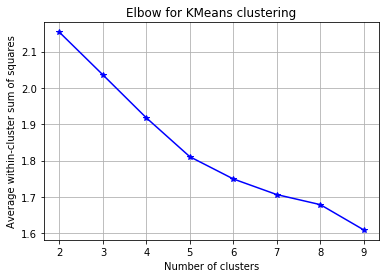

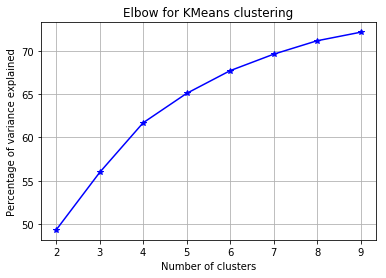

In [183]:
# Code FROM Unisse Chua which also is from the ADS lab session on Silhouette scores

range_n_clusters = range(2,10)

'''
for n_clusters in range_n_clusters:
    
    silhouette_avg = silhouette_score(df_ny, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
'''
    
elbow(df_ny,range_n_clusters)

Fig. 1. The results for Elbow Test for k-means clustering. As the two graphs suggest there are no clear elbow point for number of cluster for the time series. The smooth trend does not provide any clear indications for which number of clusters to choose. 

In [145]:
# based on professor Bianco suggestion that should limit cluster numbers to single digits 

# this part of code is from Unisse Chua's github upload

n = 5

km = KMeans(n_clusters=n, random_state=999)
km_res = km.fit(df_ny)

df_ny['KLABEL'] = km_res.labels_

centersKM = pd.DataFrame(km_res.cluster_centers_)
centersKM.columns = df_ny.columns[: -1]
centersKM.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,-1.261151,-1.209763,-1.120511,-0.998020,-0.902588,-0.873517,-0.756670,-0.660690,-0.324023,-0.195824,...,0.084305,0.132629,0.350511,0.496028,0.630690,0.897549,1.069446,1.299702,1.575983,1.806066
1,0.274678,0.617233,0.748553,0.862297,0.984689,1.039467,1.130373,0.826945,0.012162,-0.075462,...,-0.147389,-0.145769,-0.380674,-0.493293,-0.569397,-0.776861,-0.933500,-0.931536,-0.976435,-0.969342
2,-0.940495,-0.844224,-0.712416,-0.378653,-0.298608,-0.207286,0.309707,0.537699,0.800678,0.880751,...,0.833242,0.520268,0.186618,-0.109121,-0.468407,-0.540096,-0.819274,-0.433498,0.023420,0.093902
3,-1.927769,-1.610688,-1.337537,-0.952469,-0.781821,-0.576209,-0.421342,-0.409692,-0.061595,0.135818,...,0.530573,0.609018,0.663567,0.639014,0.640192,0.715260,0.793376,0.839873,0.952433,1.147992
4,1.311606,0.729505,0.174259,-0.284775,-0.563514,-0.149250,-0.572453,-0.656862,-0.811500,-0.926248,...,-0.293039,-0.316264,-0.093364,-0.168972,0.031999,0.138426,0.304090,0.698764,0.773749,1.145352


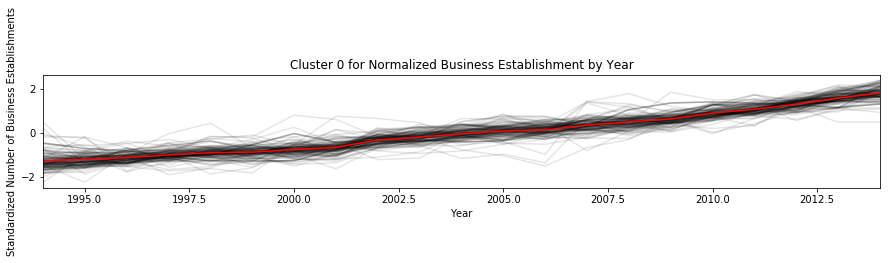

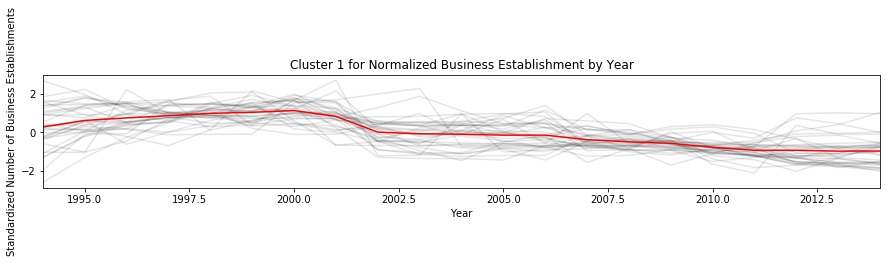

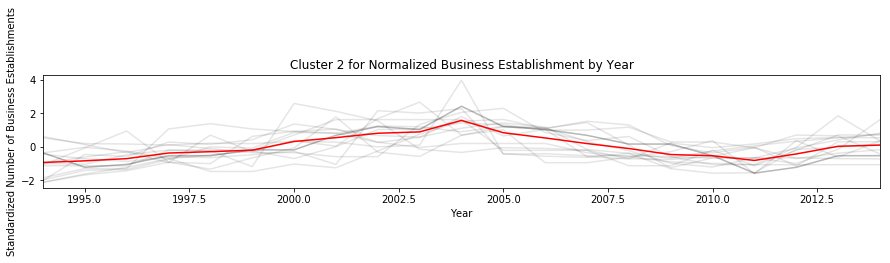

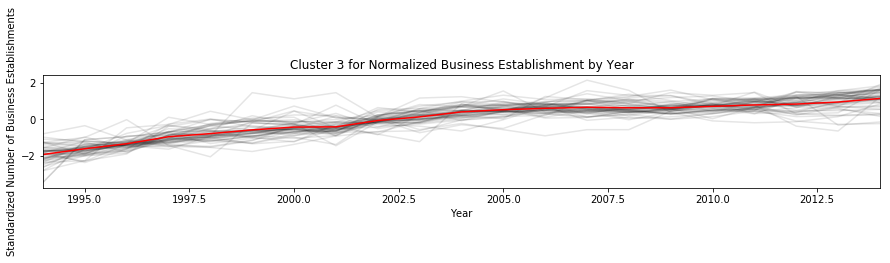

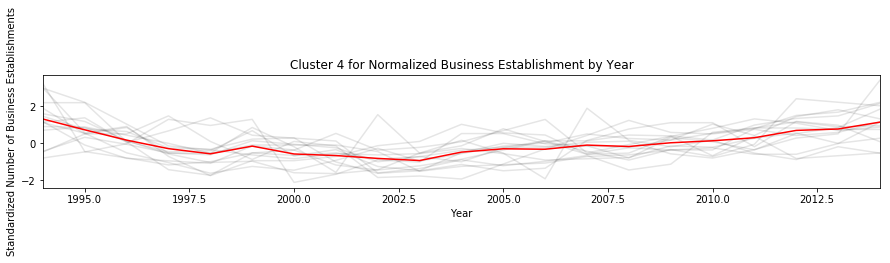

In [159]:
# plotting the k-means results for the five clusters

for i in range(n):
    fig = pl.figure(figsize=(15,12))
    ax = fig.add_subplot(5, 1, i+1)
    
    km_clusters = df_ny[df_ny.KLABEL == i]
    ax.plot(km_clusters.iloc[:, :-1].T, c='k', alpha=0.1)
    ax.plot(centersKM.iloc[i], c='r')
    ax.set_title('Cluster %d for Normalized Business Establishment by Year' % i)
    ax.set_xlim([1994, 2014])
    ax.set_xlabel('Year')
    ax.set_ylabel('Standardized Number of Business Establishments')

Fig 1. K-means clusters for normalized business establishments by year. Cluster 0 and cluster 3 are the clusters with the most times series in them. Both of those clusters have a slight upward trend which is highlighted by the red line representing the cluster mean. Cluster 1 has a small dip between 2000 and 2002. Cluster 2 has a signature of a small spike in between 2002 and 2005. Cluster 4 does not have any strong pattern. 

## plotting the choropleth with the five clusters

In [167]:
shp_zip = shp[['ZIPCODE', 'geometry']]
shp_zip.ZIPCODE = shp_zip.ZIPCODE.astype('int')

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [170]:
gdf = pd.merge(shp_zip, df_ny.reset_index(), left_on='ZIPCODE', right_on='zip', how='inner')

gdf.head()

,ZIPCODE,geometry,zip,1994,1995,1996,1997,1998,1999,2000,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,KLABEL
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",11436,-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,...,0.190385,0.395415,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853,0
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",11213,-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,...,0.023569,-0.058923,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875,0
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",11212,-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,-0.897644,...,-0.296543,-0.092169,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464,0
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",11225,-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,-0.841764,...,0.027251,0.186217,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007,0
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",11218,-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,-0.665648,...,0.116050,0.327569,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331,0


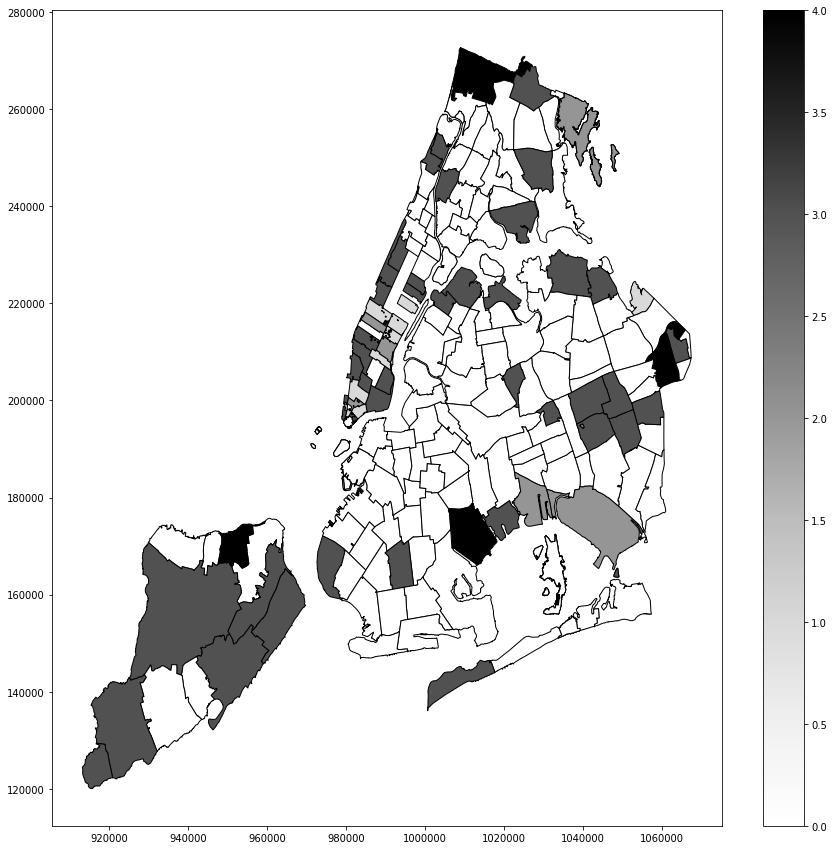

In [177]:
fig = pl.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

gdf.plot(ax = ax, column='KLABEL', cmap='Greys', edgecolor='black', legend=True) 

Fig. 2. A choropleth of the k-means clusters. Different colors are for different clusters. There are few interesting features in this map. 1)The most striking is the vast area in Brooklyn, Queens, Upper East Mahattan and Bronx are clustered into the cluster 0. This makes intuitive sense that those areas went through steady growth in the past two decades and it confirms the slight upward trend observed in the mean of the . 2)  the Staten Island region is grouped almost into one single cluster. This could mean that the business establishments in that area experience the same temporal transformation. 3) The region in Lower Mahattan are also clusters together which also experience steady growth but with less drastic trend. 

# 

In [ ]:
from sklearn.cluster import AgglomerativeClustering
agc = AgglomerativeClustering(n_clusters=5,  compute_full_tree=True).fit(dy_nc)
labelsag = agc.labels_